# Testbed for diversity combining with data transmission signals
- Focus: MRC & EGC combining
- Understanding Theory & fit to complex signals (4-QAM)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Generate complex 4-QAM signals

mean power: 1.4142135623730956
mean power (after normalization): 1.00


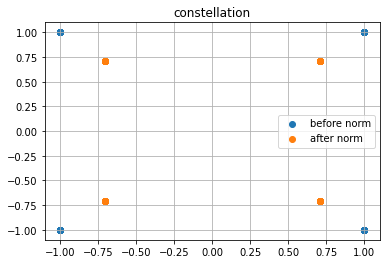

In [56]:
order = 4
symbols_amount = 10000

#generate some 4-QAM style samples
symbols_with_0 = np.random.default_rng().integers(-1,2,size=int(symbols_amount*np.log2(order)))+1j*np.random.default_rng().integers(-1,2,size=int(symbols_amount*np.log2(order)))

#remove some stuff which should not be there
for i in range(len(symbols_with_0)):
    if np.real(symbols_with_0[i])==0 or np.imag(symbols_with_0[i])==0:
        symbols_with_0[i] = np.nan
symbols_before_norm = symbols_with_0[~np.isnan(symbols_with_0)]



print("mean power: " + str(np.mean(np.abs(symbols_before_norm))))
mag_const = 1
mag_samples = np.mean(np.abs(symbols_before_norm))
symbols = symbols_before_norm * (mag_const / mag_samples)
print("mean power (after normalization): {:.2f}".format(np.mean(np.abs(symbols))))

plt.figure()
plt.title("constellation")
plt.scatter(np.real(symbols_before_norm), np.imag(symbols_before_norm), label="before norm")
plt.scatter(np.real(symbols), np.imag(symbols), label="after norm")
plt.legend()
plt.grid()
plt.show()

### 2. Generate some different AWGN-Channel out of these symbols

In [109]:
n_dims = 6
snr_list_dB = [15,30,12,3,10,11]

channel_array = np.zeros((n_dims,len(symbols)), dtype=complex)

for i in range(n_dims):
    channel_array[i,:] = np.sqrt(10**(snr_list_dB[i]/10))*symbols+np.random.default_rng().standard_normal(size=symbols.size)

### 3. Combine these AWGN-Channels
- MRC: combining ideally with known SNR of each branch

In [107]:
mrc_sig = np.zeros(len(symbols), dtype=complex)
egc_sig = np.zeros(len(symbols), dtype=complex)

for i in range(n_dims):
    mrc_sig += channel_array[i,:]*10**(snr_list_dB[i]/10)
    egc_sig += channel_array[i,:]

#normalize them for easier work
mrc_sig =  mrc_sig * (1 / np.mean(np.abs(mrc_sig)))
egc_sig =  egc_sig * (1 / np.mean(np.abs(egc_sig)))

### Estimate SNR & compare to theory
M  = number of RX Apertures
- SNR estimation method with known TX symbols: $$SNR = \frac{\sigma^2_{Sig}}{\sigma^2_{Noise}}$$


- Theory of MRC: combined signal SNR should be the sum of single SNRs: $$\gamma_{\Sigma} = \sum_{m=1}^M \gamma_{M}$$


- Theory of EGC: something different, the performance should be less than MRC: $$\gamma_{\Sigma} = \frac{1}{M} \cdot \left( \sum_{m=1}^M \gamma_{M} \right )^2$$
  

In [108]:
theory_mrc = 10*np.log10(np.sum([10**(x/10) for x in snr_list_dB]))
snr_mrc = 10*np.log10(np.var(symbols)/np.var(mrc_sig-symbols))

print("MRC: // theory: {:.2f}dB // measured: {:.2f}dB // diff: {:.2f}dB".format(theory_mrc,snr_mrc,theory_mrc-snr_mrc))

theory_egc = 10*np.log10((1/n_dims)*(np.sum([np.sqrt(10**(x/10)) for x in snr_list_dB])**2))
snr_egc = 10*np.log10(np.var(symbols)/np.var(egc_sig-symbols))

print("EGC: // theory: {:.2f}dB // measured: {:.2f}dB // diff: {:.2f}dB".format(theory_egc,snr_egc,theory_egc-snr_egc))


MRC: // theory: 30.30dB // measured: 30.14dB // diff: 0.16dB
EGC: // theory: 26.08dB // measured: 26.05dB // diff: 0.04dB
